In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch.nn as nn
import sys, os
sys.path.append(os.path.abspath("../src"))
from torch.utils.data import TensorDataset, DataLoader
from node.lib.odst import ODST
import idx2numpy as idx2np

In [2]:
# Load MNIST data
train_images = idx2np.convert_from_file("../data/mnist-dataset/train-images.idx3-ubyte")
train_labels = idx2np.convert_from_file("../data/mnist-dataset/train-labels.idx1-ubyte")
test_images = idx2np.convert_from_file("../data/mnist-dataset/t10k-images.idx3-ubyte")
test_labels = idx2np.convert_from_file("../data/mnist-dataset/t10k-labels.idx1-ubyte")

# Flatten images and normalize
X_train = train_images.reshape((train_images.shape[0], -1)) / 255.0
X_test = test_images.reshape((test_images.shape[0], -1)) / 255.0
y_train = train_labels
y_test = test_labels

In [4]:
input_dim = X_train.shape[1]  # 784
num_classes = 10

model = nn.Sequential(
    ODST(
        in_features=input_dim,
        num_trees=256,
        depth=4,
        tree_dim=2,
        flatten_output=True
    ),
    nn.Linear(256 * 2, num_classes)
)

In [6]:
# Prepare DataLoaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Use class weights if needed (MNIST is fairly balanced, so optional)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
model.train()
for epoch in range(10):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

/Users/ozgun/Desktop/cs454/CS454-Project/src/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


Epoch 1, Loss: 0.3048
Epoch 2, Loss: 0.0387
Epoch 3, Loss: 0.0615
Epoch 4, Loss: 0.0475
Epoch 5, Loss: 0.1049
Epoch 6, Loss: 0.0769
Epoch 7, Loss: 0.0375
Epoch 8, Loss: 0.0474
Epoch 9, Loss: 0.0665
Epoch 10, Loss: 0.0674


Accuracy: 0.9772
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



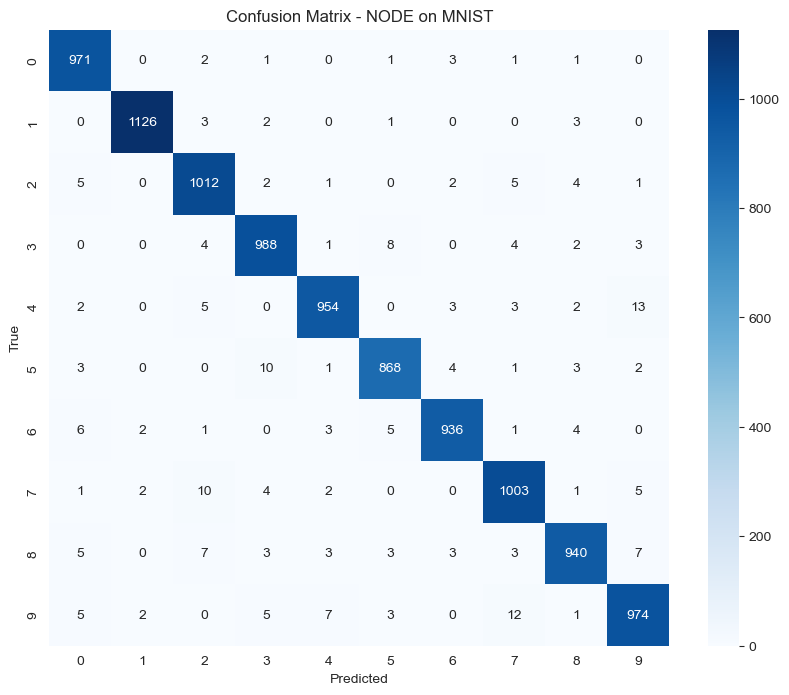

In [7]:
# Inference
model.eval()
with torch.no_grad():
    y_pred_logits = model(torch.tensor(X_test, dtype=torch.float32))
    y_pred = torch.argmax(y_pred_logits, dim=1).numpy()

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - NODE on MNIST")
plt.show()